# Estimation

Chapter intro...

In [114]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [115]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## The German Tank Problem

To motivate the idea of estimation...

In [117]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

<IPython.core.display.Javascript object>

In [124]:
import pandas as pd

df = pd.read_csv("penguins_raw.csv").dropna(subset=["Body Mass (g)"])

<IPython.core.display.Javascript object>

In [135]:
np.random.seed(17)
adelie = df.query('Species.str.startswith("Adelie")')
weights = adelie["Body Mass (g)"] / 1000
weights.describe()

count    151.000000
mean       3.700662
std        0.458566
min        2.850000
25%        3.350000
50%        3.700000
75%        4.000000
max        4.775000
Name: Body Mass (g), dtype: float64

<IPython.core.display.Javascript object>

## Weighing penguins

Suppose you are a researcher at Palmer Station in Antarctica, studying local populations of penguins.
One of your tasks is to monitor the average weight of the penguins as it varies over the course of the year.
It would be impractical to weigh every penguin in the environment, so your plan is to collect a random sample of 10 penguins each week, weigh them, and use the sample to estimate the mean of the entire population -- which is called the **population mean**.

There are many ways you could use the sample to estimate the population mean, but we'll consider just two: the sample mean and the sample median.
They are both reasonable choices, but let's see which is better -- and think about what we mean by "better".

For purposes of experiment, we'll start with the assumption that the penguins' weights are drawn from a normal distribution, and that we know the actual mean and standard deviation of that distribution, in kilograms -- which I'll denote `mu` and `sigma`.

In [136]:
mu = 3.7
sigma = 0.46

<IPython.core.display.Javascript object>

With these parameters, we can use NumPy to simulate the sampling process and generate a sample of any size.
For example, here's a hypothetical sample of 10 weights.

In [138]:
sample = np.random.normal(mu, sigma, size=10)
sample

array([4.69877822, 4.23006272, 2.86334632, 3.6364973 , 3.94832622,
       2.88337015, 4.30484321, 3.4822139 , 3.19757425, 3.58498738])

<IPython.core.display.Javascript object>

And here are the mean and median of the sample.

In [139]:
np.mean(sample), np.median(sample)

(3.6829999658891546, 3.6107423400049)

<IPython.core.display.Javascript object>

Because the normal distribution is symmetric, the mean and median are not very different.
But they are different enough that we should wonder which is a better estimate.

To find out, we'll use the following function to generate hypothetical samples with the given size, `n`.

In [141]:
def make_sample(n):
    return np.random.normal(mu, sigma, size=n)

<IPython.core.display.Javascript object>

As a first experiment, let's see how the sample mean and sample median behave as the sample size increases.
We'll use `logspace` to make a range of `ns` from 1 to 10,000, equally space on a logarithmic scale.

In [142]:
ns = np.logspace(1, 5).astype(int)

<IPython.core.display.Javascript object>

For each value of `n`, we'll generate a hypothetical sample and compute it's mean. 

In [143]:
means = [np.mean(make_sample(n)) for n in ns]

<IPython.core.display.Javascript object>

And we'll do the same for the median.

In [144]:
medians = [np.median(make_sample(n)) for n in ns]

<IPython.core.display.Javascript object>

The following figure shows how the sample mean and median behave as we increase the sample size.
The horizontal line shows the actual mean in the population.

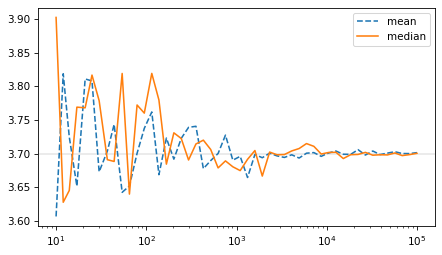

<IPython.core.display.Javascript object>

In [145]:
plt.axhline(mu, color="0.9")
plt.plot(ns, means, "--", label="mean")
plt.plot(ns, medians, label="median")

decorate(xscale="log")

For both estimators, the estimates converge to the actual value as the sample size increases.
This demonstrates that both estimators are **consistent**, which is one of the properties a good estimator should have.
Based on this property, mean and median seem equally good. 

In the previous figure, you might notice that the estimates are sometimes too high and sometimes too low -- and it looks like the variation is roughly symmetric around the true value.
And that suggests another experiment: if we collect many samples with the same size and compute the sample mean, what is the average of the means?

The following loop simulates this scenario, collecting 1001 samples of 10 penguins and computing the mean of each sample.

In [146]:
means = [np.mean(make_sample(n=10)) for i in range(1001)]
np.mean(means)

3.699988241223501

<IPython.core.display.Javascript object>

The average of the means is very close to the actual mean we used to generate the samples: 3.7 kg.
The following loop simulates the same scenario, but this time it computes the median of each sample.

In [147]:
medians = [np.median(make_sample(n=10)) for i in range(1001)]
np.mean(medians)

3.6992674642726935

<IPython.core.display.Javascript object>

The mean of these hypothetical medians is also very close to the actual population mean.
And if we increase the number of samples, it gets closer and closer.

These results demonstrate that the sample mean and sample median are **unbiased** estimators, which means that they are right on average.
The word "bias" means different things in different contexts, which can be a source of confusion.
In this context, it means that the average of the estimates is the actual value.

So far, we've shown that both estimators are consistent and unbiased, but it's still not clear which is better.
Let's try one more experiment: let's see which estimator is more accurate.
The word "accurate" also means different things in different contexts -- to be more specific, let's consider the **mean squared error** (MSE).

The following function takes a sequence of estimates and the actual value, computes the differences between the estimates and the actual values, and returns the average of the squares of these errors.

In [148]:
def mse(estimates, actual):
    """Mean squared error of a sequence of estimates."""
    errors = np.asarray(estimates) - actual
    return np.mean(errors**2)

<IPython.core.display.Javascript object>

In [149]:
mse(means, mu)

0.021559792615083447

<IPython.core.display.Javascript object>

In [150]:
mse(medians, mu)

0.02958052005772322

<IPython.core.display.Javascript object>

In practice, of course, we don't know `actual`.
If we did, we wouldn't have to estimate it. The purpose of this experiment is to compare the performance of the two estimators.

Notice that we need to know the actual value

In [59]:
def mae(estimates, actual):
    """Computes the mean absolute error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float MAE
    """
    errors = np.asarray(estimates) - actual
    return np.mean(np.abs(errors))

<IPython.core.display.Javascript object>

In [60]:
mae(means, 10)

0.0784394201664938

<IPython.core.display.Javascript object>

In [61]:
mae(medians, 10)

0.09968087496606018

<IPython.core.display.Javascript object>

## Robustness

In [62]:
def make_sample_with_errors(n):
    mu, sigma = 10, 1
    sample = np.random.normal(mu, sigma, size=n)
    factor = np.random.choice([1, 10], p=[0.99, 0.01], size=n)
    return sample * factor

<IPython.core.display.Javascript object>

In [63]:
sample = make_sample_with_errors(n=1000)

<IPython.core.display.Javascript object>

In [64]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(sample)

<IPython.core.display.Javascript object>

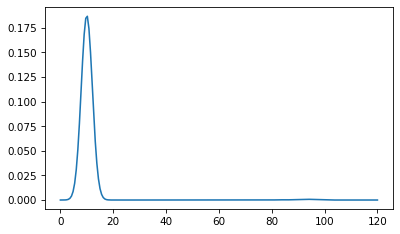

<IPython.core.display.Javascript object>

In [65]:
from thinkstats import Pdf

domain = 0, 120
pdf = Pdf(kde, domain)
pdf.plot()

In [82]:
means = [np.mean(make_sample_with_errors(n=100)) for i in range(10001)]
np.mean(means)

10.916260292822704

<IPython.core.display.Javascript object>

In [83]:
medians = [np.median(make_sample_with_errors(n=100)) for i in range(10001)]
np.mean(medians)

10.011866023381195

<IPython.core.display.Javascript object>

In [69]:
mse(means, 10), mse(medians, 10)

(1.591930738008331, 0.0159623040767279)

<IPython.core.display.Javascript object>

The results depend on random numbers, so they vary from one run to the next.
But most often we expect the sample mean to yield a lower RMSE than the sample median.

Minimizing MSE is a nice property, but it's not always the best strategy.
For example, suppose we are estimating the distribution of wind speeds at a building site.
If the estimate is too high, we might overbuild the structure, increasing its cost.
But if it's too low, the building might collapse.
Because cost as a function of error is not symmetric, minimizing MSE is not the best strategy.

## Guess the variance

*I'm thinking of a distribution.* It's a normal distribution, and here's a (familiar) sample:

`[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]`

What do you think is the variance, $\sigma^2$, of my distribution? Again, the obvious choice is to use the sample variance, $S^2$, as an estimator.


$$S^2 = \frac{1}{n} \sum (x_i - \bar{x})^2$$ 

For large samples, $S^2$ is an adequate estimator, but for small samples it tends to be too low.
Because of this unfortunate property, it is called a **biased** estimator.
An estimator is **unbiased** if the expected total (or mean) error, after many iterations of the estimation game, is 0.

Fortunately, there is another simple statistic that is an unbiased estimator of $\sigma^2$:

$$S_{n-1}^2 = \frac{1}{n-1} \sum (x_i - \bar{x})^2$$

For an explanation of why $S^2$ is biased, and a proof that $S_{n-1}^2$ is unbiased, see <http://wikipedia.org/wiki/Bias_of_an_estimator>.

Remember from Chapter 1 that there are two definitions of variance:

* The **population variance** has `n` in the denominator.

* The **sample variance** has `n-1` in the denominator.

In [76]:
def pvar(xs):
    """Population variance with n in the denominator"""
    return np.var(xs, ddof=0)

<IPython.core.display.Javascript object>

In [77]:
def svar(xs):
    """Sample variance with n-1 in the denominator"""
    return np.var(xs, ddof=1)

<IPython.core.display.Javascript object>

In [94]:
pvars = [pvar(make_sample(n=10)) for i in range(100001)]
np.mean(pvars)

0.8976306880269037

<IPython.core.display.Javascript object>

In [95]:
svars = [svar(make_sample(n=10)) for i in range(100001)]
np.mean(svars)

1.0010222190101532

<IPython.core.display.Javascript object>

In [96]:
mse(pvars, 1), mse(svars, 1)

(0.19029448179380304, 0.22063875362151075)

<IPython.core.display.Javascript object>

In [97]:
pvars = [pvar(make_sample(n=100)) for i in range(10001)]
np.mean(pvars)

0.9914506561716301

<IPython.core.display.Javascript object>

In [98]:
svars = [svar(make_sample(n=100)) for i in range(10001)]
np.mean(svars)

0.9983085340441913

<IPython.core.display.Javascript object>

In [99]:
mse(pvars, 1), mse(svars, 1)

(0.01977832963707464, 0.02036425241678166)

<IPython.core.display.Javascript object>

When I ran this code, the mean error for $S^2$ was -0.13. As expected, this biased estimator tends to be too low.
For $S_{n-1}^2$, the mean error was 0.014, about 10 times smaller.
As `m` increases, we expect the mean error for $S_{n-1}^2$ to approach 0.

Properties like MSE and bias are long-term expectations based on many iterations of the estimation game.
By running simulations like the ones in this chapter, we can compare estimators and check whether they have desired properties.

But when you apply an estimator to real data, you just get one estimate.
It would not be meaningful to say that the estimate is unbiased; being unbiased is a property of the estimator, not the estimate.

After you choose an estimator with appropriate properties, and use it to generate an estimate, the next step is to characterize the uncertainty of the estimate, which is the topic of the next section.

## Exponential distributions

Let's play one more round of the estimation game.
*I'm thinking of a distribution.* It's an exponential distribution, and here's a sample:

`[5.384, 4.493, 19.198, 2.790, 6.122, 12.844]`

What do you think is the parameter, $\lambda$, of this distribution?

In general, the mean of an exponential distribution is $1/\lambda$, so working backwards, we might choose 

$$L= 1 / \bar{x}$$

$L$ is an estimator of $\lambda$.
And not just any estimator; it is also the maximum likelihood estimator (see <http://wikipedia.org/wiki/Exponential_distribution#Maximum_likelihood>).
So if you want to maximize your chance of guessing $\lambda$ exactly, $L$ is the way to go.

But we know that $\bar{x}$ is not robust in the presence of outliers, so we expect $L$ to have the same problem.

We can choose an alternative based on the sample median.
The median of an exponential distribution is $\ln(2) / \lambda$, so working backwards again, we can define an estimator $$L_m= \ln(2) / m$$ where $m$ is the sample median.

To test the performance of these estimators, we can simulate the sampling process:

In [16]:
def median(seq):
    n = len(seq)
    t = sorted(seq)
    i = (n - 1) // 2
    return t[i]

<IPython.core.display.Javascript object>

In [17]:
lam = 2
ls = []
lms = []

for _ in range(iters):
    xs = np.random.exponential(1.0 / lam, n)
    L = 1 / np.mean(xs)
    Lm = np.log(2) / median(xs)
    ls.append(L)
    lms.append(Lm)

<IPython.core.display.Javascript object>

In [18]:
print("rmse L", rmse(ls, lam))
print("rmse Lm", rmse(lms, lam))

rmse L 0.8560691042601719
rmse Lm 1.753367380943278


<IPython.core.display.Javascript object>

When I run this experiment with $\lambda=2$, the RMSE of $L$ is 1.1. For the median-based estimator $L_m$, RMSE is 1.8. We can't tell from this experiment whether $L$ minimizes MSE, but at least it seems better than $L_m$.

In [19]:
print("mean error L", mean_error(ls, lam))
print("mean error Lm", mean_error(lms, lam))

mean error L 0.2540278485011342
mean error Lm 0.7173415794334793


<IPython.core.display.Javascript object>

Sadly, it seems that both estimators are biased.
For $L$ the mean error is 0.33; for $L_m$ it is 0.45. And neither converges to 0 as `m` increases.

It turns out that $\bar{x}$ is an unbiased estimator of the mean of the distribution, but $L$ is not an unbiased estimator of $\lambda$.

## Sampling distributions

Suppose you are a scientist studying gorillas in a wildlife preserve.
You want to know the average weight of the adult female gorillas in the preserve.
To weigh them, you have to tranquilize them, which is dangerous, expensive, and possibly harmful to the gorillas.
But if it is important to obtain this information, it might be acceptable to weigh a sample of 9 gorillas.
Let's assume that the population of the preserve is well known, so we can choose a representative sample of adult females.
We could use the sample mean, $\bar{x}$, to estimate the unknown population mean, $\mu$.

Having weighed 9 female gorillas, you might find $\bar{x}=90$ kg and sample standard deviation, $S=7.5$ kg. The sample mean is an unbiased estimator of $\mu$, and in the long run it minimizes MSE.
So if you report a single estimate that summarizes the results, you would report 90 kg.

But how confident should you be in this estimate? If you only weigh $n=9$ gorillas out of a much larger population, you might be unlucky and choose the 9 heaviest gorillas (or the 9 lightest ones) just by chance.
Variation in the estimate caused by random selection is called **sampling error**.

To quantify sampling error, we can simulate the sampling process with hypothetical values of $\mu$ and $\sigma$, and see how much $\bar{x}$ varies.

Since we don't know the actual values of $\mu$ and $\sigma$ in the population, we'll use the estimates $\bar{x}$ and $S$.
So the question we answer is: "If the actual values of $\mu$ and $\sigma$ were 90 kg and 7.5 kg, and we ran the same experiment many times, how much would the estimated mean, $\bar{x}$, vary?"

The following function answers that question:

In [11]:
def simulate_sample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

<IPython.core.display.Javascript object>

`mu` and `sigma` are the *hypothetical* values of the parameters.
`n` is the sample size, the number of gorillas we measured.
`m` is the number of times we run the simulation.

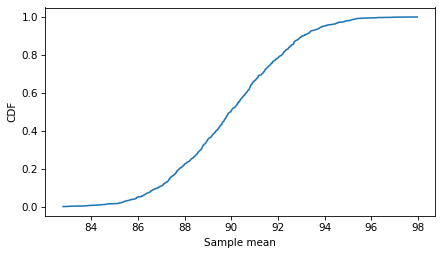

<IPython.core.display.Javascript object>

In [12]:
from empiricaldist import Cdf

xbars = simulate_sample()
cdf = Cdf.from_seq(xbars)
cdf.plot()
decorate(xlabel="Sample mean", ylabel="CDF")

In each iteration, we choose `n` values from a normal distribution with the given parameters, and compute the sample mean, `xbar`.
We run 1000 simulations and then compute the distribution, `cdf`, of the estimates.
The result is shown in Figure [\[estimation1\]](#estimation1){reference-type="ref" reference="estimation1"}.
This distribution is called the **sampling distribution** of the estimator.
It shows how much the estimates would vary if we ran the experiment over and over.

The mean of the sampling distribution is pretty close to the hypothetical value of $\mu$, which means that the experiment yields the right answer, on average.
After 1000 tries, the lowest result is 82 kg, and the highest is 98 kg. This range suggests that the estimate might be off by as much as 8 kg.

In [13]:
np.mean(xbars)

89.97975274187043

<IPython.core.display.Javascript object>

In [14]:
# TODO: make this a function

ci = cdf.inverse([0.05, 0.95])
ci

array([85.9691665 , 93.89352504])

<IPython.core.display.Javascript object>

In [15]:
stderr = rmse(xbars, 90)
stderr

2.4328629138051032

<IPython.core.display.Javascript object>

There are two common ways to summarize the sampling distribution:

-   **Standard error** (SE) is a measure of how far we expect the estimate to be off, on average.
For each simulated experiment, we compute the error, $\bar{x} - \mu$, and then compute the root mean squared error (RMSE).
In this example, it is roughly 2.5 kg.

-   A **confidence interval** (CI) is a range that includes a given fraction of the sampling distribution.
For example, the 90% confidence interval is the range from the 5th to the 95th percentile.
In this example, the 90% CI is $(86, 94)$ kg.

Standard errors and confidence intervals are the source of much confusion:

-   People often confuse standard error and standard deviation.
Remember that standard deviation describes variability in a measured quantity; in this example, the standard deviation of gorilla weight is 7.5 kg. Standard error describes variability in an estimate.
In this example, the standard error of the mean, based on a sample of 9 measurements, is 2.5 kg.

One way to remember the difference is that, as sample size increases, standard error gets smaller; standard deviation does not.

-   People often think that there is a 90% probability that the actual parameter, $\mu$, falls in the 90% confidence interval.
Sadly, that is not true.
If you want to make a claim like that, you have to use Bayesian methods (see my book, *Think Bayes*).

The sampling distribution answers a different question: it gives you a sense of how reliable an estimate is by telling you how much it would vary if you ran the experiment again.

It is important to remember that confidence intervals and standard errors only quantify sampling error; that is, error due to measuring only part of the population.
The sampling distribution does not account for other sources of error, notably sampling bias and measurement error, which are the topics of the next section.

## Sampling bias

Suppose that instead of the weight of gorillas in a nature preserve, you want to know the average weight of women in the city where you live.
It is unlikely that you would be allowed to choose a representative sample of women and weigh them.

A simple alternative would be "telephone sampling;" that is, you could choose random numbers from the phone book, call and ask to speak to an adult woman, and ask how much she weighs.

Telephone sampling has obvious limitations.
For example, the sample is limited to people whose telephone numbers are listed, so it eliminates people without phones (who might be poorer than average) and people with unlisted numbers (who might be richer).
Also, if you call home telephones during the day, you are less likely to sample people with jobs.
And if you only sample the person who answers the phone, you are less likely to sample people who share a phone line.

If factors like income, employment, and household size are related to weight---and it is plausible that they are---the results of your survey would be affected one way or another.
This problem is called **sampling bias** because it is a property of the sampling process.

This sampling process is also vulnerable to self-selection, which is a kind of sampling bias.
Some people will refuse to answer the question, and if the tendency to refuse is related to weight, that would affect the results.

Finally, if you ask people how much they weigh, rather than weighing them, the results might not be accurate.
Even helpful respondents might round up or down if they are uncomfortable with their actual weight.
And not all respondents are helpful.
These inaccuracies are examples of **measurement error**.

When you report an estimated quantity, it is useful to report standard error, or a confidence interval, or both, in order to quantify sampling error.
But it is also important to remember that sampling error is only one source of error, and often it is not the biggest.

## Glossary

-   **estimation**: The process of inferring the parameters of a distribution from a sample.

-   **estimator**: A statistic used to estimate a parameter.

-   **mean squared error (MSE)**: A measure of estimation error.

-   **root mean squared error (RMSE)**: The square root of MSE, a more meaningful representation of typical error magnitude.

-   **maximum likelihood estimator (MLE)**: An estimator that computes the point estimate most likely to be correct.

-   **bias (of an estimator)**: The tendency of an estimator to be above or below the actual value of the parameter, when averaged over repeated experiments.

-   **sampling error**: Error in an estimate due to the limited size of the sample and variation due to chance.

-   **sampling bias**: Error in an estimate due to a sampling process that is not representative of the population.

-   **measurement error**: Error in an estimate due to inaccuracy collecting or recording data.

-   **sampling distribution**: The distribution of a statistic if an experiment is repeated many times.

-   **standard error**: The RMSE of an estimate, which quantifies variability due to sampling error (but not other sources of error).

-   **confidence interval**: An interval that represents the expected range of an estimator if an experiment is repeated many times.

## Exercises

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2.
Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



In [20]:
# Solution

lam = 2
estimates = []
for _ in range(iters):
    xs = np.random.exponential(1.0 / lam, n)
    lamhat = 1.0 / np.mean(xs)
    estimates.append(lamhat)
stderr = rmse(estimates, lam)
print("standard error", stderr)

standard error 0.9017891711693963


<IPython.core.display.Javascript object>

In [21]:
# Solution

cdf = Cdf.from_seq(estimates)
ci = cdf.inverse([0.05, 0.95])
print("confidence interval", ci)

confidence interval [1.24258435 3.8582495 ]


<IPython.core.display.Javascript object>

In [22]:
# Solution

import matplotlib.pyplot as plt


def vert_line(x, y=1):
    plt.plot([x, x], [0, y], color="gray")

<IPython.core.display.Javascript object>

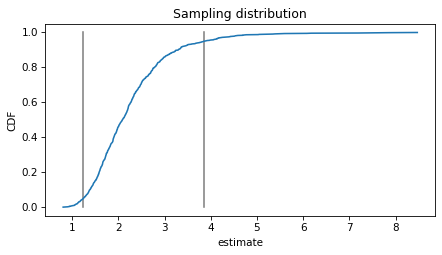

<IPython.core.display.Javascript object>

In [23]:
# Solution

vert_line(ci[0])
vert_line(ci[1])
cdf.plot()
decorate(xlabel="estimate", ylabel="CDF", title="Sampling distribution")

**Exercise:** In games like hockey and soccer, the time between goals is roughly exponential.
So you could estimate a team's goal-scoring rate by observing the number of goals they score in a game.
This estimation process is a little different from sampling the time between goals, so let's see how it works.

Write a function that takes a goal-scoring rate, `lam`, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.

Write another function that simulates many games, stores the estimates of `lam`, then computes their mean error and RMSE.

Is this way of making an estimate biased?

In [24]:
def simulate_game(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1
    L = goals
    return L

<IPython.core.display.Javascript object>

In [25]:
# Solution

lam = 2

estimates = []
for i in range(iters):
    L = simulate_game(lam)
    estimates.append(L)
print("Experiment 4")
print("rmse L", rmse(estimates, lam))
print("mean error L", mean_error(estimates, lam))

Experiment 4
rmse L 1.453233674220396
mean error L 0.015984015984015984


<IPython.core.display.Javascript object>

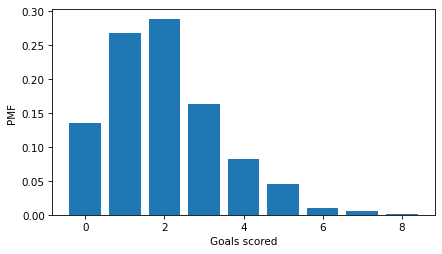

<IPython.core.display.Javascript object>

In [26]:
# Solution

from empiricaldist import Pmf

pmf = Pmf.from_seq(estimates)
pmf.bar()
decorate(xlabel="Goals scored", ylabel="PMF")

### Exercise

Check whether $S_n$ or $S_{n-1}$ is an unbiased estimate of the population standard deviation, $\sigma$.

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE.
Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [27]:
n = 7
iters = 1001

mu = 0
sigma = 1
means = []
medians = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    xbar = np.mean(xs)
    median = np.median(xs)
    means.append(xbar)
    medians.append(median)

print("mean error xbar", mean_error(means, mu))
print("mean error median", mean_error(medians, mu))

mean error xbar 0.018458590041731
mean error median 0.019914102450594582


<IPython.core.display.Javascript object>

In [28]:
n = 7
iters = 1001

mu = 0
sigma = 1
estimates1 = []
estimates2 = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    biased = np.var(xs)
    unbiased = np.var(xs, ddof=1)
    estimates1.append(biased)
    estimates2.append(unbiased)
print("RMSE biased", rmse(estimates1, sigma**2))
print("RMSE unbiased", rmse(estimates2, sigma**2))

RMSE biased 0.5286359123121629
RMSE unbiased 0.5994651143057945


<IPython.core.display.Javascript object>

### Exercise (or maybe example)

Hot hand experiment